In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from stm.register import lattice
from stm.segment.segmentation import segment_neighbors
from stm.utils.plotutils import add_colorbar
from scipy.interpolate import griddata

In [2]:
def continuum_strain(x, y, W, A):
    
    w = 1 / W**2 / 2

    exx = A * (x + y) * np.exp(-w * (x**2 + y**2))
    eyy = A * (x - y) * np.exp(-w * (x**2 + y**2))

    exy = A / 2 * \
        ((np.exp(-w * y**2) * (np.sqrt(np.pi)/(2 * np.sqrt(w)) - 
        np.sqrt(np.pi) * np.sqrt(w) * y**2) * erf(np.sqrt(w) * x) + 
        y * np.exp(w * (-x**2 - y**2))) +
        (np.exp(-w * x**2) * (np.sqrt(np.pi)/(2 * np.sqrt(w)) -
        np.sqrt(np.pi) * np.sqrt(w) * x**2) * erf(np.sqrt(w) * y) - 
        x * np.exp(w * (-x**2 - y**2))))

    return exx, eyy, exy

def displace_points(points, W, A):
    
    new_points = points.copy()
    
    x = points[:,0]
    y = points[:,1]
    
    w = 1 / W**2 / 2
    
    new_points[:,0] += A * (-np.exp(w * (-x**2 - y**2))/(2 * w) + 
                    (np.exp(-w * y**2) * np.sqrt(np.pi) * 
                    y * erf(np.sqrt(w) * x))/(2 * np.sqrt(w)))

    new_points[:,1] += A * (np.exp(w * (-x**2 - y**2))/(2 * w) +
                    (np.exp(-w * x**2) * np.sqrt(np.pi) * 
                    x * erf(np.sqrt(w) * y))/(2 * np.sqrt(w)))
    
    return new_points

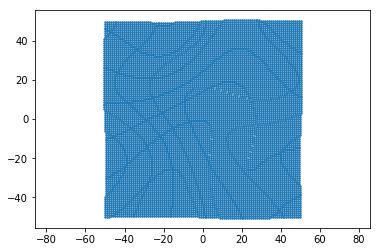

In [3]:
shape=(100,)*2

L = 1

a=np.array([0,1])*L
b=np.array([1,0])*L

#a = np.array([0, 1])
#b = np.array([np.sin(2/3*np.pi), np.cos(2/3*np.pi)])

W=20
A=0.002

points = lattice.create_lattice(a, b, size=shape, origin=(0,0)) - shape[0]/2

displaced_points = displace_points(points,W,A)

plt.scatter(displaced_points[:,0],displaced_points[:,1],s=2)
plt.axis('equal');

In [4]:
n=5

segments = segment_neighbors(displaced_points, n_points = n)

template = lattice.create_template(a, b, n_points=n)

segments.match(template, rmsd_max=.1)

#segments.calibrate_strain(proportiontocut=.4)

In [5]:
x,y=np.indices(shape)-shape[0]/2

exx_true, eyy_true, exy_true = continuum_strain(x,y,W,A)

In [6]:
rmsd = segments.rmsd
strain = segments.strain

exx = griddata(segments.origins[rmsd.mask==0], strain[rmsd.mask==0][:,0,0], (x,y), method='cubic')
eyy = griddata(segments.origins[rmsd.mask==0], strain[rmsd.mask==0][:,1,1], (x,y), method='cubic')
exy = griddata(segments.origins[rmsd.mask==0], strain[rmsd.mask==0][:,0,1], (x,y), method='cubic')

exx_err = np.abs(exx-exx_true)
eyy_err = np.abs(eyy-eyy_true)
exy_err = np.abs(exy-exy_true)

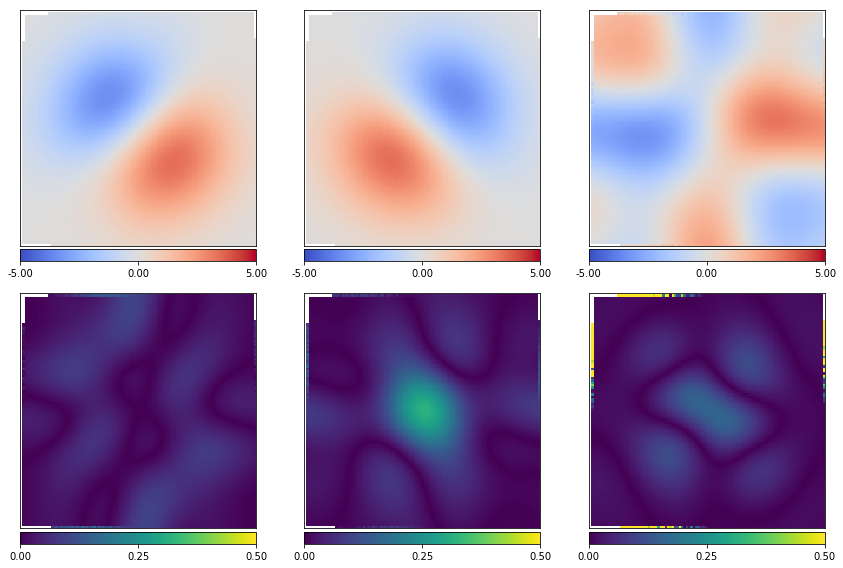

In [7]:
lim=5
err_lim=0.5

fig,axes=plt.subplots(2,3,figsize=(12,8))

ticks = np.linspace(-lim,lim,3)
m = axes[0,0].imshow(exx*100, vmin=-lim, vmax=lim, cmap='coolwarm')
cbar = add_colorbar(axes[0,0], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

m = axes[0,1].imshow(eyy*100, vmin=-lim, vmax=lim, cmap='coolwarm')
cbar = add_colorbar(axes[0,1], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

m = axes[0,2].imshow(exy*100, vmin=-lim, vmax=lim, cmap='coolwarm')
cbar = add_colorbar(axes[0,2], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

ticks = np.linspace(0,err_lim,3)
m = axes[1,0].imshow(exx_err*100, vmin=0, vmax=err_lim)
cbar = add_colorbar(axes[1,0], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

m = axes[1,1].imshow(eyy_err*100, vmin=0, vmax=err_lim)
cbar = add_colorbar(axes[1,1], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

m = axes[1,2].imshow(exy_err*100, vmin=0, vmax=err_lim)
cbar = add_colorbar(axes[1,2], m, loc='bottom', ticks=ticks)
cbar.ax.set_xticklabels(['%.2f' % i for i in ticks])

for ax in axes.ravel():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()